In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

In [2]:
df = pd.read_csv("preprocessed_eeg_features.csv")
print(df.shape)

(30, 664)


In [3]:
df['internet_addiction_level'] = df['internet_addiction_level'].replace({'Moderate level': 'Severe Level'})

In [4]:
from sklearn.preprocessing import LabelEncoder

le_gender = LabelEncoder()
le_internet_addiction = LabelEncoder()

df['gender_encoded'] = le_gender.fit_transform(df['gender'])
df['internet_addiction_level_encoded'] = le_internet_addiction.fit_transform(df['internet_addiction_level'])


In [5]:
X = df.drop(columns = ['gender', 'internet_addiction_level', 'personality', 'internet_addiction_level_encoded'])
y = df['internet_addiction_level_encoded']

In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

print("Training size:", len(X_train))
print("Test size:", len(X_test))

Training size: 24
Test size: 6


In [7]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X_train_scaled = sc.fit_transform(X_train)
X_test_scaled = sc.transform(X_test)

In [8]:
from sklearn.decomposition import PCA

pca = PCA(n_components=0.95)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

In [9]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(k_neighbors = 2, random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_pca, y_train)

print("After SMOTE - Training size:", len(X_train_resampled))
print("Class distribution:\n", pd.Series(y_train_resampled).value_counts())

c:\Users\Hrishikesh\anaconda3\envs\myenv\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


After SMOTE - Training size: 42
Class distribution:
 internet_addiction_level_encoded
0    14
2    14
1    14
Name: count, dtype: int64


In [10]:
def augment_features_and_labels(X, y, n_augmentations=5, noise_level=0.01, scale_range=(0.9, 1.1), max_shift=2):
    augmented_X = []
    augmented_y = []

    for _ in range(n_augmentations):
        X_aug = X.copy()

        operation = np.random.choice(['noise', 'scale', 'rolling'])

        if operation == 'noise':
            noise = np.random.normal(0, noise_level, X_aug.shape)
            X_aug += noise

        elif operation == 'scale':
            scale_factors = np.random.uniform(scale_range[0], scale_range[1], X_aug.shape[1])
            X_aug *= scale_factors

        elif operation == 'rolling':
            for col_idx in range(X.shape[1]):
                shift = np.random.randint(-max_shift, max_shift + 1)
                X_aug[:, col_idx] = np.roll(X[:, col_idx], shift)

        augmented_X.append(X_aug)
        augmented_y.append(y)

    X_augmented = np.vstack(augmented_X)
    y_augmented = np.concatenate(augmented_y)

    return X_augmented, y_augmented

In [11]:
X_train_aug, y_train_aug = augment_features_and_labels(X_train_resampled, y_train_resampled, n_augmentations=5)

print("Resampled training size:", X_train_resampled.shape)
print("Augmented training size:", X_train_aug.shape)

Resampled training size: (42, 19)
Augmented training size: (210, 19)


## ML Models

In [12]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import seaborn as sns

In [13]:
def evaluate_model_with_cv(model, param_grid, X_real, y_real, X_aug, y_aug, model_name="Model"):
    # Step 1: Grid Search on Augmented Data
    grid = GridSearchCV(model, param_grid, cv=StratifiedKFold(n_splits=5), scoring='f1_macro', n_jobs=-1)
    grid.fit(X_aug, y_aug)

    best_model = grid.best_estimator_
    print(f"\n---- {model_name} Best Params ----")
    print(grid.best_params_)

    # Step 2: Cross-Validation on Real (non-augmented) data
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    all_preds = []
    all_true = []

    y_real = np.array(y_real)

    for train_idx, val_idx in skf.split(X_real, y_real):
        X_tr, X_val = X_real[train_idx], X_real[val_idx]
        y_tr, y_val = y_real[train_idx], y_real[val_idx]

        best_model.fit(X_tr, y_tr)
        preds = best_model.predict(X_val)

        all_preds.extend(preds)
        all_true.extend(y_val)

    print(f"\n---- {model_name} Cross-Validation Report ----")
    print(classification_report(all_true, all_preds))

    cm = confusion_matrix(all_true, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f"{model_name} - Cross-Validation Confusion Matrix")
    plt.show()

    return best_model

In [14]:
def evaluate_model(y_true, y_pred, model_name):
    print(classification_report(y_true, y_pred))

    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f"{model_name} - Test Set Confusion Matrix")
    plt.show()

### SVM


---- SVM Best Params ----
{'C': 10, 'kernel': 'rbf'}

---- SVM Cross-Validation Report ----
              precision    recall  f1-score   support

           0       0.78      0.50      0.61        14
           1       0.93      1.00      0.97        14
           2       0.67      0.86      0.75        14

    accuracy                           0.79        42
   macro avg       0.79      0.79      0.77        42
weighted avg       0.79      0.79      0.77        42



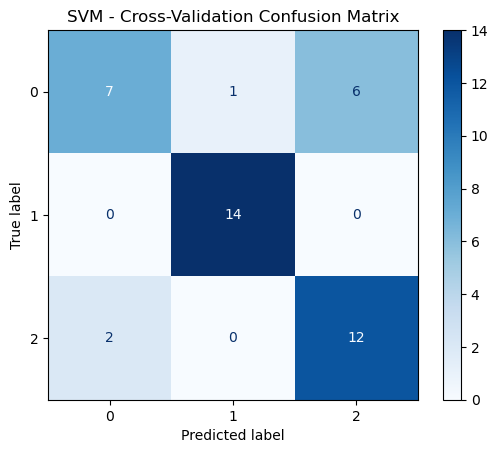

In [15]:
from sklearn.svm import SVC

svm_param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf']
}

best_svm = evaluate_model_with_cv(
    model=SVC(),
    param_grid=svm_param_grid,
    X_real=X_train_resampled,      # real (non-augmented) training set
    y_real=y_train_resampled,
    X_aug=X_train_aug,   # augmented training set
    y_aug=y_train_aug,
    model_name="SVM"
)


### Random Forest Classification


---- Random Forest Best Params ----
{'max_depth': 5, 'n_estimators': 100}

---- Random Forest Cross-Validation Report ----
              precision    recall  f1-score   support

           0       0.67      0.57      0.62        14
           1       0.88      1.00      0.93        14
           2       0.71      0.71      0.71        14

    accuracy                           0.76        42
   macro avg       0.75      0.76      0.75        42
weighted avg       0.75      0.76      0.75        42



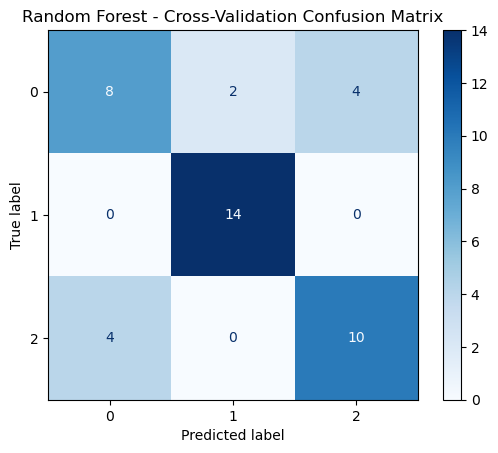

In [16]:
rf_param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [5, 10, None]
}

best_rf = evaluate_model_with_cv(
    model=RandomForestClassifier(random_state=42),
    param_grid=rf_param_grid,
    X_real=X_train_resampled,      # real (resampled, non-augmented)
    y_real=y_train_resampled,
    X_aug=X_train_aug,             # full augmented set
    y_aug=y_train_aug,
    model_name="Random Forest"
)

### XGBoost


---- XGBoost Best Params ----
{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50}

---- XGBoost Cross-Validation Report ----
              precision    recall  f1-score   support

           0       0.64      0.50      0.56        14
           1       0.87      0.93      0.90        14
           2       0.62      0.71      0.67        14

    accuracy                           0.71        42
   macro avg       0.71      0.71      0.71        42
weighted avg       0.71      0.71      0.71        42



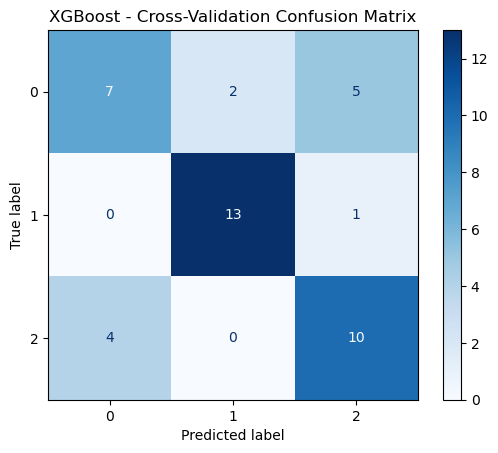

In [17]:
xgb_param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [3, 5],
    'learning_rate': [0.05, 0.1]
}

best_xgb = evaluate_model_with_cv(
    model=XGBClassifier(eval_metric='mlogloss', random_state=42),
    param_grid=xgb_param_grid,
    X_real=X_train_resampled,
    y_real=y_train_resampled,
    X_aug=X_train_aug,
    y_aug=y_train_aug,
    model_name="XGBoost"
)

In [18]:
import joblib
joblib.dump(best_svm, f'best_model_svm.pkl')


['best_model_svm.pkl']